## Adding Kondo Hamiltonian to the circuit

In [3]:
#Let us first see how reset works

import qiskit
from qiskit import QuantumCircuit

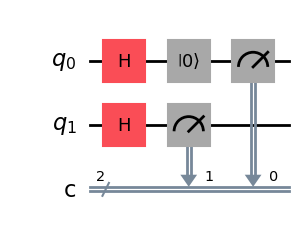

In [4]:
qr = QuantumCircuit(2,2)
qr.h([0,1])
qr.reset(0)

qr.measure([0,1],[0,1])

qr.draw(output = "mpl")

In [5]:
from qiskit_aer import QasmSimulator

simulator = QasmSimulator()
job = simulator.run(qr)
result = job.result()
counts = result.get_counts(qr)

print(counts)

{'00': 532, '10': 492}


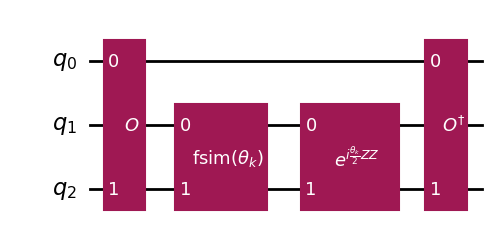

In [6]:
# NOw that we know reset works, let us make a subroutine for the kondo circuit involving this reset procedure

from qiskit.quantum_info import Operator
import math as m
import cmath as cm

import numpy as np

def zz_rotation(rz_angle):
    z_rotation = Operator([[cm.exp(1j*rz_angle/2),0,0,0],
                   [0,cm.exp(-1j*rz_angle/2),0,0],
                   [0,0,cm.exp(-1j*rz_angle/2),0],
                   [0,0,0,cm.exp(1j*rz_angle/2)]])
    return z_rotation
    
def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

transform = Operator([[0,1,0,0],
                   [0,0,1,0],
                   [0,0,0,1],
                   [1,0,0,0]])
tranform_adj = transform.adjoint()

def kondo_step(theta_k):
    qc = QuantumCircuit(3)
    qc.unitary(transform,[0,2],label=r"$O$")
    #qc.reset(0)
    qc.unitary(fsim(theta_k,0,0),[1,2],label = r'fsim$(\theta_k)$')
    qc.unitary(zz_rotation(theta_k/2),[1,2],label = r'$e^{i\frac{\theta_k}{2}ZZ}$')
    qc.unitary(tranform_adj,[0,2],label = r'$O^\dag$')

    #qc = qc.to_gate()
    

    return qc

qc = kondo_step(np.pi/3)
qc.draw(output='mpl')


## Forming the final qc involving kondo_step

In [7]:
def circuit(num_qubits, pos1, trotter_steps,angles = [0,0,0],theta_k = 0, num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.x(pos1-1)
    qc.barrier()
    c = num_qubits//2
    for trotter_step in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.append(kondo_step(theta_k),[c-1,c,c+1])
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def add_fsim_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta,phi,beta)

    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    

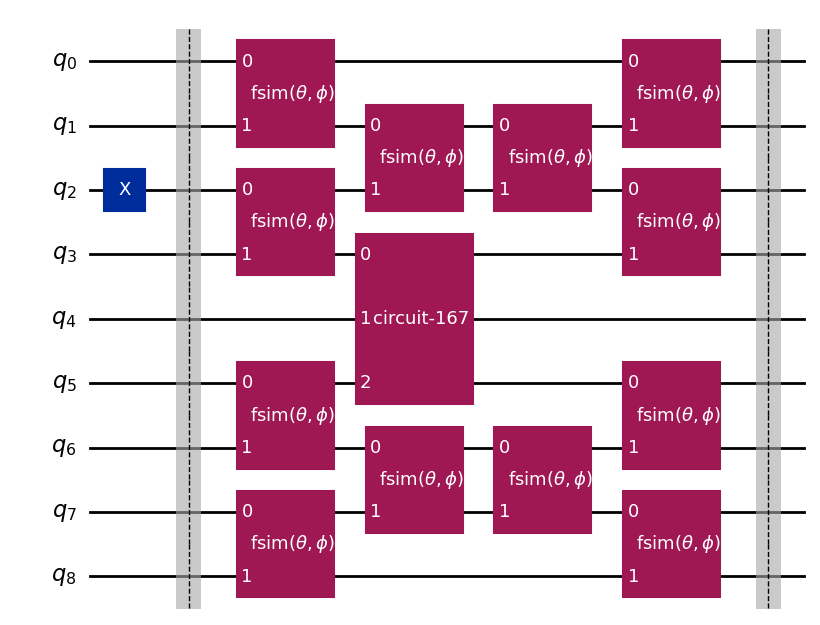

In [8]:
num_qubits = 9
trotter_steps = 1
pos1 = 3
angles = [np.pi/4,0,0]
qc = circuit(num_qubits,pos1,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')

In [9]:
print(qc.depth())  #will reduce to 4 as the odd layered gates are added together

5


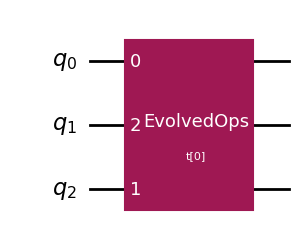

In [10]:
from qiskit.circuit.library import EvolvedOperatorAnsatz as exp_M
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp

theta_k = 0.1
theta_z = 0.1

op_x = Operator([[0,1,0,0],
                   [1,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])
op_y = Operator([[0,-1j,0,0],
                   [1j,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])
op_z = Operator([[1,0,0,0],
                   [0,-1,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])

X = SparsePauliOp("X")
Y = SparsePauliOp("Y")
Z = SparsePauliOp("Z")

fin_op = theta_k*(op_x ^ X) + theta_k*(op_y ^ Y) + theta_z*(op_z ^ Z)

#print(fin_op)
evo = exp_M(fin_op, reps=1)

circ = QuantumCircuit(3)
circ.append(evo,[0,2,1])
circ.draw(output='mpl')






In [11]:
def circuit_2(num_qubits, pos1, trotter_steps,angles = [0,0,0],theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.x(pos1-1)
    qc.barrier()
    c = num_qubits//2
    for trotter_step in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.append(kondo_step_2(theta_k,theta_z),[c-1,c+1,c])
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

def kondo_step_2(theta_k,theta_z):  #forming the block matrices
    op_x = Operator([[0,1,0,0],
                   [1,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])
    op_y = Operator([[0,-1j,0,0],
                   [1j,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])
    op_z = Operator([[1,0,0,0],
                   [0,-1,0,0],
                   [0,0,0,0],
                   [0,0,0,0]])

    X = SparsePauliOp("X")
    Y = SparsePauliOp("Y")
    Z = SparsePauliOp("Z")
    fin_op = theta_k*(op_x ^ X) + theta_k*(op_y ^ Y) + theta_z*(op_z ^ Z)
    evo = exp_M(fin_op, reps=1)

    return evo

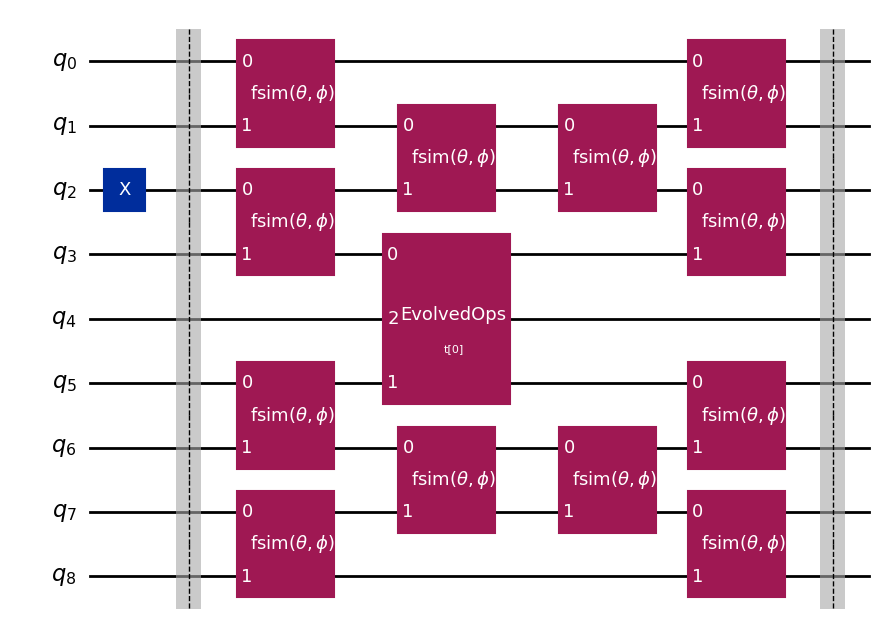

In [12]:
num_qubits = 9
trotter_steps = 1
pos1 = 3
angles = [np.pi/4,0,0]
qc = circuit_2(num_qubits,pos1,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')

In [13]:
qc.depth()


5

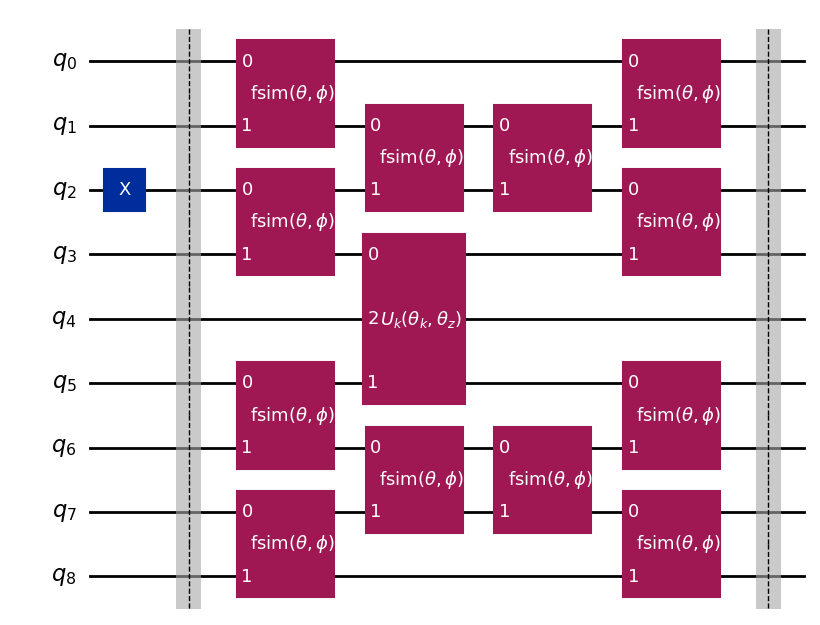

In [15]:
# Let us use the direct 8 by 8 unitary now for the problem
import math as m
import cmath as cm

def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary

def circuit_3(num_qubits, pos1, trotter_steps,angles = [0,0,0],theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.x(pos1-1)
    qc.barrier()
    c = num_qubits//2
    for trotter_step in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c-1,c+1,c],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    return qc

qc = circuit_3(num_qubits,pos1,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl')